In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [31]:
data = pd.read_csv('../Data/loan_data.csv')
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
data.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

# <b><span style='color:#CDE8E5'>Step 2.1 |</span><span style='color:#4D869C'> Handling Missing Values</span></b>

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>percentage of missing values</p>
</span>
</div>

In [4]:
(data.isnull().sum()[data.isnull().sum() > 0] / data.shape[0]) * 100

Series([], dtype: float64)

# <b><span style='color:#CDE8E5'>Step 2.2 |</span><span style='color:#4D869C'> Handling Duplicates</span></b>

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>Showing the number of duplicate rows</p>
</span>
</div>

In [5]:
print(f"\nThe dataset contains {data.duplicated().sum()} duplicate rows.")


The dataset contains 0 duplicate rows.


<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>finding and show duplicated rows by following code:</p>
<code style='background-color:#FFFFFF; color: #4D869C'>data[data.duplicated(keep=False)].head(5)</code>
</span>
</div>

<a id="eda"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px;  padding: 15px;">Step 3 | Data Preprocessing:</p>
⬆️ [Tabel of Contents](#contents_tabel)

# <b><span style='color:#CDE8E5'>Step 3.1 |</span><span style='color:#4D869C'> Label Encoder:</span></b>

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['purpose'] = label_encoder.fit_transform(data['purpose'])
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# <b><span style='color:#CDE8E5'>Step 3.2 |</span><span style='color:#4D869C'> Normalize features</span></b>

In [7]:
def normal_dis(data, feature:str):
  # create new column
  data[feature] = np.sqrt(data[feature])

  # visualize
  sns.histplot(x=data[feature], label=data[feature].name, kde =True)
  plt.legend()
  plt.title(f'Distribution of {data[feature].name}')
  plt.show()

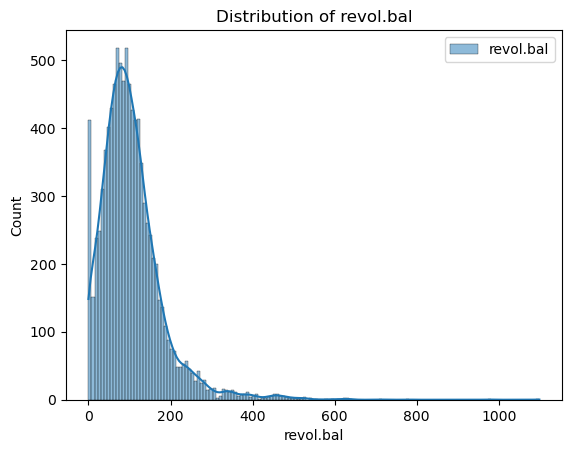

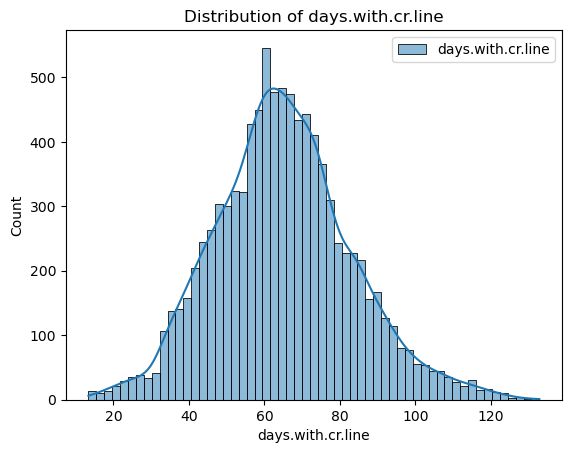

In [8]:
unnormal_features = ["revol.bal", "days.with.cr.line"]
for i in unnormal_features:
  normal_dis(data, i)

In [9]:
fico_labels = range(1,5)
fico = pd.qcut(data["fico"], q=4, labels=fico_labels)
data["fico"] = fico


revol_util_labels = range(1,5)
revol_util = pd.qcut(data["revol.util"], q=4, labels=revol_util_labels)
data["revol.util"] = revol_util


inq_last_6mths_labels = range(1,5)
inq_last_6mths = pd.cut(data["inq.last.6mths"], bins=4, labels= inq_last_6mths_labels)
data["inq.last.6mths"] = inq_last_6mths


delinq_2yrs_labels = range(1,5)
delinq_2yrs = pd.cut(data["delinq.2yrs"], bins=4, labels= delinq_2yrs_labels)
data["delinq.2yrs"] = delinq_2yrs


pub_rec_labels = range(1,5)
pub_rec = pd.cut(data["pub.rec"], bins=4, labels= pub_rec_labels)
data["pub.rec"] = pub_rec


# <b><span style='color:#CDE8E5'>Step 3.3 |</span><span style='color:#4D869C'> Treating Imbalanced data</span></b>


<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>
create two different dataframe of majority and minority class then upsampling minority class</p>
<p>

</span>
</div>

In [10]:
df_majority = data[(data['not.fully.paid']==0)]
df_minority = data[(data['not.fully.paid']==1)]

df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples= 8045, # to match majority class
                                 random_state=60)  # reproducible results

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>
Combine majority class with upsampled minority class</p>
<p>

</span>
</div>

In [11]:
data_upsampled = pd.concat([df_minority_upsampled, df_majority])

# <b><span style='color:#CDE8E5'>Step 3.4 |</span><span style='color:#4D869C'> Split the Dataset:</span></b>

In [12]:
X = data_upsampled.iloc[:, :-1].values
y = data_upsampled.iloc[:, -1].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state =100)

# <b><span style='color:#CDE8E5'>Step 3.5 |</span><span style='color:#4D869C'> Feature Scaling:</span></b>

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<ol>
  <li>Initialize the StandardScaler</li>
  <li>Fit the scaler on the training data and transform it</li>
  <li>Only transform the testing data</li>
</ol>
</span>
</div>

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id="modeling"></a>
# <p style="background-color: #4D869C; font-family:calibri; color:white; font-size:135%; font-family:Verdana; text-align:center; border-radius:15px 50px;  padding: 15px;">Step 4 | Neural Networks</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [15]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test , num_classes=2)

In [16]:
initializer = tf.keras.initializers.HeNormal(seed=None)

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>Now we defining a model and then complie it</p>
</span>
</div>

In [17]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=X_train.shape[1:]),
        tf.keras.layers.Dense(256, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.Dense(256, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99),
        tf.keras.layers.Dense(128, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.Dense(128, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99),
        tf.keras.layers.Dense(64, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.Dense(64, activation="relu", kernel_initializer=initializer),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,866 (519.01 KB)

 Trainable params: 132,098 (516.01 KB)

 Non-trainable params: 768 (3.00 KB)

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>We can see the neural network architecture by the following code:</p>
<p><code style='background-color:#FFFFFF; color: #4D869C'>plot_model(model, show_layer_activations=True, show_shapes=True)</code></p>
<p>and then training the model :</p>
</span>
</div>

In [20]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=128)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.5531 - loss: 0.8803 - val_categorical_accuracy: 0.5976 - val_loss: 0.6740
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.6461 - loss: 0.6274 - val_categorical_accuracy: 0.6352 - val_loss: 0.6336
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.6872 - loss: 0.5842 - val_categorical_accuracy: 0.6700 - val_loss: 0.6007
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7228 - loss: 0.5514 - val_categorical_accuracy: 0.7032 - val_loss: 0.5705
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7471 - loss: 0.5155 - val_categorical_accuracy: 0.7197 - val_loss: 0.5537
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.7700 - loss: 0.4954 - val_categorical_accuracy: 0.7387 - val_loss: 0.5326
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.785

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9803 - loss: 0.0646 - val_categorical_accuracy: 0.9105 - val_loss: 0.2741
Epoch 45/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9831 - loss: 0.0588 - val_categorical_accuracy: 0.9077 - val_loss: 0.2805
Epoch 46/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9815 - loss: 0.0617 - val_categorical_accuracy: 0.9142 - val_loss: 0.2621
Epoch 47/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9783 - loss: 0.0680 - val_categorical_accuracy: 0.9024 - val_loss: 0.3111
Epoch 48/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9783 - loss: 0.0663 - val_categorical_accuracy: 0.9062 - val_loss: 0.3077
Epoch 49/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9829 - loss: 0.0550 - val_categorical_accuracy: 0.9121 - val_loss: 0.2828
Epoch 50/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9807 - lo

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9917 - loss: 0.0235 - val_categorical_accuracy: 0.9217 - val_loss: 0.3189
Epoch 88/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9948 - loss: 0.0189 - val_categorical_accuracy: 0.9093 - val_loss: 0.3717
Epoch 89/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9929 - loss: 0.0240 - val_categorical_accuracy: 0.9226 - val_loss: 0.3081
Epoch 90/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9889 - loss: 0.0305 - val_categorical_accuracy: 0.9208 - val_loss: 0.3280
Epoch 91/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9933 - loss: 0.0235 - val_categorical_accuracy: 0.9158 - val_loss: 0.3576
Epoch 92/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9927 - loss: 0.0268 - val_categorical_accuracy: 0.9229 - val_loss: 0.3196
Epoch 93/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9918 - lo

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>Now we go through the following steps to evaluate the model:</p>
</span>
</div>

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9151 - loss: 0.3323
Loss: 0.33100032806396484, Accuracy: 0.9192044734954834


In [22]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes)
print(report)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1580
           1       0.87      0.99      0.93      1638

    accuracy                           0.92      3218
   macro avg       0.93      0.92      0.92      3218
weighted avg       0.93      0.92      0.92      3218



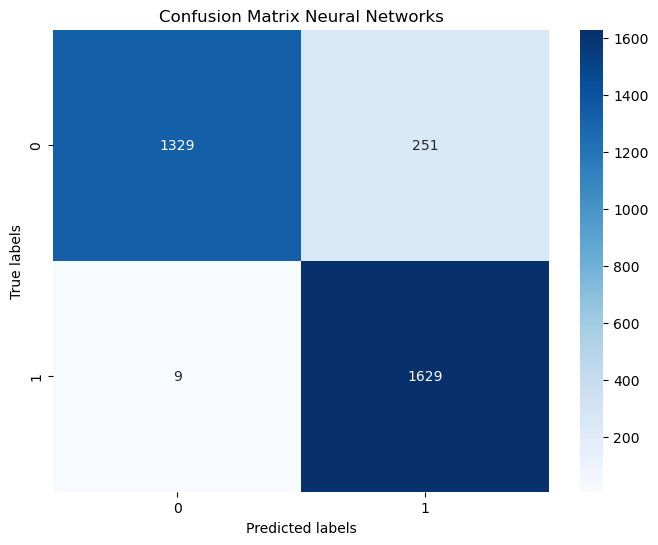

In [23]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Neural Networks')
plt.show()

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>Finally, by performing the following steps, we save the model with the values ​​obtained from the training</p>
</span>
</div>

In [24]:
import pickle

with open('label_encoder.h5', 'wb') as f:
    pickle.dump(label_encoder, f)

In [25]:
with open('scaler.h5', 'wb') as f:
    pickle.dump(scaler, f)

In [26]:
model.save("my_model.keras")

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<h2>Prediction:</h2>
<h3>By doing the following steps, we make a prediction from a new data by the model we have trained</h3>
</span>
</div>

In [32]:
newx = list(data.iloc[1, :-1].values)
newx

[1,
 'credit_card',
 0.1071,
 228.22,
 11.08214255,
 14.29,
 707,
 2760.0,
 33623,
 76.7,
 0,
 0,
 0]

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<p>Convert to DataFrame for easier processing</p>
</span>
</div>

In [33]:
temp_df = pd.DataFrame([newx], columns=['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec'])


In [34]:
import pickle

with open('scaler.h5', 'rb') as f:
    ss = pickle.load(f)

# load label encoder
with open('label_encoder.h5', 'rb') as f:
    le = pickle.load(f)

In [35]:
temp_df["purpose"] = le.transform(temp_df["purpose"])
temp_df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
0,1,1,0.1071,228.22,11.082143,14.29,707,2760.0,33623,76.7,0,0,0


In [36]:
temp_df.values

array([[1.00000000e+00, 1.00000000e+00, 1.07100000e-01, 2.28220000e+02,
        1.10821426e+01, 1.42900000e+01, 7.07000000e+02, 2.76000000e+03,
        3.36230000e+04, 7.67000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [37]:
newx = ss.transform(temp_df.iloc[:,:].values)
newx

array([[ 5.79264011e-01, -5.81390216e-01, -7.22990164e-01,
        -4.71103739e-01,  2.75773603e-01,  2.09882418e-01,
         6.37768904e+02,  1.49342334e+02,  4.08686190e+02,
         6.68621827e+01, -5.69292112e+00, -1.44794789e+01,
        -1.59534816e+01]])

In [38]:
loaded_model = tf.keras.models.load_model("my_model.keras")
loaded_model

<Sequential name=sequential, built=True>

In [39]:
assert np.allclose(model.predict(newx), loaded_model.predict(newx))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [ ]:
np.argmax(loaded_model.predict(newx), axis=1)[0]

<div class="warning" style='background-color:#B5EEF1; color: #4D869C; border-left: solid #4D869C 6px; border-radius: 4px; padding:0.9em;'>
<span>
<h2><center>End</center></h2>
<h3><center>Thank you for your patience</center></h3>
</span>
</div>